In [12]:
import pandas as pd
import numpy as np # módulo para manipulação de vetores e matrizes
import matplotlib.pyplot as plt
#!pip install tensorflow 
import tensorflow as tf 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm
import re
import unittest
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
from tensorflow import keras
import string
import nltk
#nltk.download_shell() baixat stopwords
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pickle
import demoji
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import json
import io

In [13]:
def FormatosNoData (dados_saude2):
    todos_formatos =[]
    for i in range(dados_saude2.shape[0]):
        todos_formatos.append(dados_saude2.Formato[i])
    todos_formatos = set(todos_formatos)
    print(todos_formatos)
    

In [14]:
def LinksDasNoticias(a):
    
    links =[]
    for i in a.index:
        l = a.Link[i] 
        l= l.rstrip('/')
        links.append(l)
    #for i in range(len(links)):
        #print(i,links[i])
    return links
    

In [15]:
#normalizando as frases
def normalize(data):
    normalized = []
    for i in data.Frase:
        i = i.lower()
        normalized.append(i)
    return normalized

In [16]:
#normalizando as frases
def normalizeTweet(data):
    normalized = []
    for i in data.tweet:
        e = demoji.findall_list(i ,True )
        if e:
            a = demoji.replace_with_desc(i)
            i = re.sub(e[0], ' ',a)
        i = re.sub("\n", ' ',i)
        i = re.sub("'", ' ',i)
        i = i.replace("'","")
        #i = re.sub('...', '',i)
        i = re.sub("-", '',i)
        i = i.lower()
        normalized.append(i)
    return normalized

In [17]:
noticias= pd.read_csv('Banco_completo_utf8.csv',sep=';',header=0,encoding='utf-8')
noticias_sem_tweets= pd.read_csv('Banco_completo_sem_tweets_utf8.csv',sep=';',header=0,encoding='utf-8')

In [18]:
noticias.head(5)

,label,preprocessed_news
0,0,katia abreu diz vai colocar expulsao moldura n...
1,0,ray peita bolsonaro conservador fake entrevist...
2,0,reinaldo azevedo desmascarado policia federal ...
3,0,relatorio assustador bndes mostra dinheiro pub...
4,0,radialista americano fala sobre pt vendem ilus...


In [19]:
#identificando linhas com menos de 2000 palavras
index_texto_incompletos = []
for i in noticias.index:
    if len(noticias.loc[i].preprocessed_news.split())>=2000:
        noticias.preprocessed_news[i]= noticias.preprocessed_news[i][:2000] 


C:\Users\GuilhermeCorrea\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
texto = noticias['preprocessed_news']
classificacao = noticias['label']

X_train, X_test, y_train, y_test = train_test_split(texto, classificacao, test_size=0.30, random_state=18)

In [21]:
#processo de dividir uma string em uma lista de tokens
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
#atualiza o vocabulário interno com base em uma lista de textos.
#Este método cria o índice de vocabulário com base na frequência das palavras
tokenizer.fit_on_texts(X_train)

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

#Converta texto em vetores, nosso classificador usa apenas dados numéricos.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#Escolho o tamanho do vetor que a minha frase vai ocupar (256 ?)
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)


In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),# Essa camada pega o vocabulário em inteiros e olha o vetor embedding em cada palavra-index. Esses vetores são aprendidos pelo modelo, ao longo do treinamento. Os vetores adicionam a dimensão ao array de saída. As dimensões resultantes são: (batch, sequence, embedding)
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),#Esse vetor de saída com tamanho fixo passa por uma camada fully-connected (Dense) layer com 64 hidden units.
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)#A última camada é uma densely connected com um único nó de saída. Usando uma função de ativação sigmoid, esse valor é um float que varia entre 0 e 1, representando a probabilidade, ou nível de confiança.
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                18560     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 390,401
Trainable params: 390,401
Non-trainable params: 0
__________________________________________________

In [23]:
#Vamos usar a parada antecipada, que para quando a perda de validação não melhora mais.
parada_antecipada = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
#Calcula a perda de entropia cruzada entre rótulos verdadeiros e rótulos previstos.
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),#classificação binário e o modelo tem como saída uma probabilidade 
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Conjunto de dados limitado e para otimizar o aprendizado e o gráfico estamos usando o Gradient Descent 
#que é um processo iterativo. Portanto, atualizar os pesos com uma única passagem ou uma época não é suficiente.
history = model.fit(X_train, y_train, epochs=15,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[parada_antecipada])

Epoch 1/15
172/172 [==============================] - 131s 762ms/step - loss: 0.6078 - accuracy: 0.5747 - val_loss: 0.4639 - val_accuracy: 0.7972
Epoch 2/15
172/172 [==============================] - 141s 818ms/step - loss: 0.4205 - accuracy: 0.7904 - val_loss: 0.3475 - val_accuracy: 0.7972
Epoch 3/15
172/172 [==============================] - 137s 794ms/step - loss: 0.3269 - accuracy: 0.8100 - val_loss: 0.2898 - val_accuracy: 0.7955
Epoch 4/15
172/172 [==============================] - 137s 796ms/step - loss: 0.2873 - accuracy: 0.8588 - val_loss: 0.2660 - val_accuracy: 0.9178
Epoch 5/15
172/172 [==============================] - 149s 867ms/step - loss: 0.2633 - accuracy: 0.8913 - val_loss: 0.2646 - val_accuracy: 0.9126
Epoch 6/15
172/172 [==============================] - 127s 737ms/step - loss: 0.2442 - accuracy: 0.9105 - val_loss: 0.2558 - val_accuracy: 0.9161
Epoch 7/15
172/172 [==============================] - 93s 542ms/step - loss: 0.2361 - accuracy: 0.9148 - val_loss: 0.2580 - 

In [24]:
model.evaluate(X_test, y_test)

77/77 [==============================] - 9s 118ms/step - loss: 0.2177 - accuracy: 0.9232


[0.21772393584251404, 0.9232339859008789]

In [25]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [26]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9232339730502246
Precision on testing set: 0.9290724863600935
Recall on testing set: 0.9247478665632273


(2.0, 0.0)

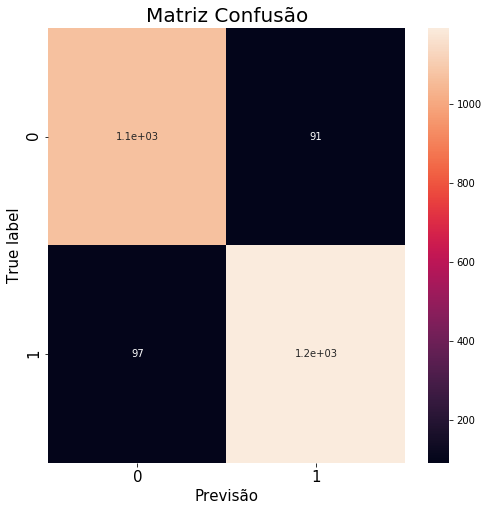

In [27]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(8, 8))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Previsão', size=15)
ax.set_ylabel('True label', size=15)
ax.set_title('Matriz Confusão', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)


In [29]:
a = "A utilização da máscara, feita de material adequado e cobrindo nariz e boca, é recomendada pela Organização Mundial de Saúde e pelo Ministério da Saúde como forma eficaz de se reduzir a transmissão do Sars-CoV-2. Médicos entrevistados pela CBN reiteram a orientação quanto ao uso do item de proteção.Além disso, a utilização passou a ser obrigatória em julho, por lei federal, em espaços públicos, como ruas e praças, nos transportes e em locais privados com acesso público, como no caso do comércio. A medida vale enquanto durar a pandemia do coronavírus no país.No vídeo viral, o homem afirma: “O uso de máscara é altamente controverso. Pode fazer sentido se você estiver doente. Mas pessoas saudáveis usarem máscara em ambientes abertos é um absurdo. O uso da máscara continuamente causa diversos problemas: baixa oxigenação"
a = np.array([a])
a = tokenizer.texts_to_sequences(a)
a = tf.keras.preprocessing.sequence.pad_sequences(a, padding='post', maxlen=80)
pred = model.predict(a)
binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1) #true
    else:
        binary_predictions.append(0) 
binary_predictions

[1]